### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
### Data Collection
import pandas_datareader as pdr
import os
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

key='2e48839e3973061bffab134187746033037381fb'

In [2]:
from tiingo import TiingoClient

config = {
    'api_key' : key,
    'session' : True
}

client = TiingoClient(config)

In [3]:
def generate_data(stock_name, start_date, client):

    data = client.get_ticker_price(stock_name, fmt='json', startDate=start_date, endDate=date.today().strftime("%Y-%m-%d"), frequency='daily')

    df = pd.DataFrame(data)
    df.to_csv(f'{stock_name}.csv')


In [ ]:
generate_data("GOOG", "2015-01-01", client)

In [4]:
df = pd.read_csv('GOOG.csv')

In [5]:
df.head()

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,2015-01-02T00:00:00.000Z,524.81,531.270,524.10,529.01,1446662,26.115161,26.436618,26.079831,26.324158,28933240,0.0,1.0
1,1,2015-01-05T00:00:00.000Z,513.87,524.330,513.06,523.26,2054238,25.570774,26.091276,25.530467,26.038031,41084760,0.0,1.0
2,2,2015-01-06T00:00:00.000Z,501.96,516.175,501.05,515.00,2891950,24.978118,25.685473,24.932835,25.627004,57839000,0.0,1.0
3,3,2015-01-07T00:00:00.000Z,501.10,507.244,499.65,507.00,2059366,24.935324,25.241056,24.863170,25.228914,41187320,0.0,1.0
4,4,2015-01-08T00:00:00.000Z,502.68,503.480,491.00,497.99,3344395,25.013946,25.053755,24.432736,24.780566,66887900,0.0,1.0


In [6]:
df.tail()

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2558,2558,2025-03-06T00:00:00.000Z,174.21,176.730,172.508,172.550,19082404,174.002619,176.519620,172.302646,172.344596,19082404,0.0,1.0
2559,2559,2025-03-07T00:00:00.000Z,175.75,176.900,172.250,173.242,16395287,175.540786,176.689417,172.044953,173.035772,16395287,0.0,1.0
2560,2560,2025-03-10T00:00:00.000Z,167.81,170.450,165.565,170.160,28335500,167.810000,170.450000,165.565000,170.160000,28335500,0.2,1.0
2561,2561,2025-03-11T00:00:00.000Z,165.98,168.655,163.240,166.680,23705899,165.980000,168.655000,163.240000,166.680000,23705899,0.0,1.0
2562,2562,2025-03-12T00:00:00.000Z,169.00,169.530,165.480,168.470,19880062,169.000000,169.530000,165.480000,168.470000,19880062,0.0,1.0


In [7]:
df1 = df.reset_index()['close']

In [8]:
df1.shape

(2563,)

In [9]:
df1

0       524.81
1       513.87
2       501.96
3       501.10
4       502.68
         ...  
2558    174.21
2559    175.75
2560    167.81
2561    165.98
2562    169.00
Name: close, Length: 2563, dtype: float64

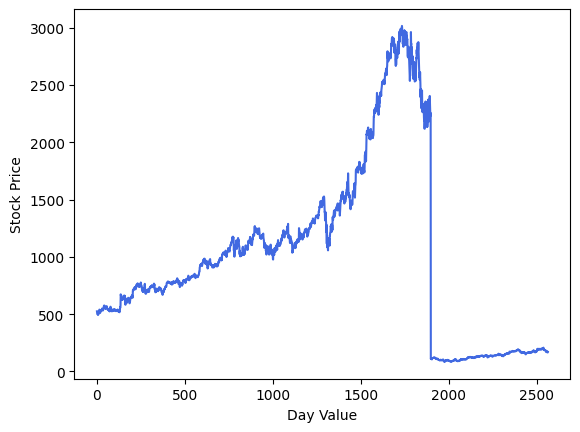

In [10]:
import matplotlib.pyplot as plt
plt.xlabel(xlabel='Day Value')
plt.ylabel(ylabel='Stock Price')
plt.plot(df1, c='#4169E1')

In [11]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.1505857 ]
 [0.14685279]
 [0.1427889 ]
 ...
 [0.02877138]
 [0.02814696]
 [0.02917743]]


In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(1665, 898)

In [16]:
train_data

array([[0.1505857 ],
       [0.14685279],
       [0.1427889 ],
       ...,
       [0.91392812],
       [0.91115062],
       [0.91592765]])

In [17]:
training_size, test_size

(1665, 898)

In [18]:
import numpy
# convert an array of values into a dataset matrix
# Time Step -> How many days before our data is dependent
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [20]:
print(X_train.shape), print(y_train.shape)

(1564, 100)
(1564,)


(None, None)

In [21]:
print(X_test.shape), print(ytest.shape)

(797, 100)
(797,)


(None, None)

In [22]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [23]:
X_train.shape

(1564, 100, 1)

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
# Model Creation
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


C:\Users\rawat\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (100,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

C:\Users\rawat\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.0000e+00 - loss: 0.0933 - val_accuracy: 0.0013 - val_loss: 0.0582
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0000e+00 - loss: 0.0115 - val_accuracy: 0.0013 - val_loss: 0.0262
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.0000e+00 - loss: 0.0070 - val_accuracy: 0.0013 - val_loss: 0.0276
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.0000e+00 - loss: 0.0051 - val_accuracy: 0.0013 - val_loss: 0.0325
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - accuracy: 0.0000e+00 - loss: 0.0054 - val_accuracy: 0.0013 - val_loss: 0.0198
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.0000e+00 - loss: 0.0041 - val_accuracy: 0.0013 - val_loss: 0.0176
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.0000e+00 - loss: 0.0038 - val_accuracy: 0.0013 - val_loss: 0.0170
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.0

In [56]:
import tensorflow as tf

In [57]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [58]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [59]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1218.1651872674051

In [60]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1201.233193074658

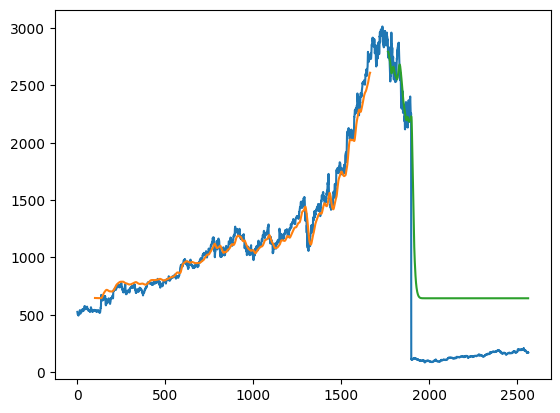

In [61]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [62]:
prev_100_day_data = len(test_data) - 100
prev_100_day_data

798

In [63]:
x_input=test_data[prev_100_day_data:].reshape(1,-1)
x_input.shape


(1, 100)

In [64]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [65]:
temp_input

[0.028406279749820008,
 0.027645366790755754,
 0.027829623740484328,
 0.028085536170662884,
 0.028433577075705718,
 0.027635130293548613,
 0.02765219112222719,
 0.028491583893212862,
 0.028952226267534267,
 0.029907632673534214,
 0.031613715541391266,
 0.030436518362569904,
 0.030422869699627052,
 0.02975067304969137,
 0.029999761148398498,
 0.03236097983751267,
 0.03370878530311974,
 0.03288304119507693,
 0.0336030081653126,
 0.034063650539634005,
 0.033098007636426924,
 0.03202658759541269,
 0.030845978250855593,
 0.03183891847994841,
 0.032787500554476934,
 0.032019763263941264,
 0.02925932118374854,
 0.028348272932312863,
 0.029324152332727105,
 0.029730200055277083,
 0.02979844336999136,
 0.029685841900712804,
 0.03053547116890561,
 0.030549119831848475,
 0.03159665471271271,
 0.030989289211755592,
 0.031733141342141266,
 0.031941283452019825,
 0.03515895574079825,
 0.03863254045975521,
 0.037581593413155256,
 0.03681385612261959,
 0.039127304491433756,
 0.038772439254919494,
 0.0

In [66]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.19108403]
101
1 day input [0.02764537 0.02782962 0.02808554 0.02843358 0.02763513 0.02765219
 0.02849158 0.02895223 0.02990763 0.03161372 0.03043652 0.03042287
 0.02975067 0.02999976 0.03236098 0.03370879 0.03288304 0.03360301
 0.03406365 0.03309801 0.03202659 0.03084598 0.03183892 0.0327875
 0.03201976 0.02925932 0.02834827 0.02932415 0.0297302  0.02979844
 0.02968584 0.03053547 0.03054912 0.03159665 0.03098929 0.03173314
 0.03194128 0.03515896 0.03863254 0.03758159 0.03681386 0.0391273
 0.03877244 0.03639416 0.03624061 0.03735298 0.03838686 0.03892599
 0.03876561 0.03772149 0.03726085 0.03649311 0.03655794 0.03741099
 0.03905906 0.03863254 0.03818213 0.03742463 0.03712436 0.03670125
 0.03872467 0.03784774 0.03891916 0.03962889 0.03976538 0.03961183
 0.04040345 0.03762936 0.03875538 0.03879291 0.04065254 0.04166596
 0.04065595 0.04238592 0.03746899 0.0374724  0.0353671  0.03572879
 0.03534321 0.03478362 0.0356196  0.03527497 0.03490987 0.03536369
 0.03519649 0.03346993 0.03333686 0

In [67]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [68]:
import matplotlib.pyplot as plt

In [69]:
len(df1)

2563

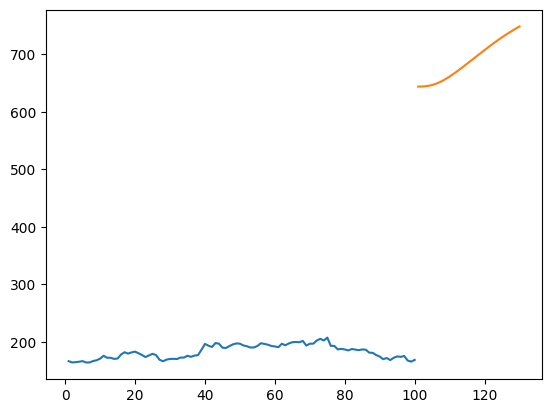

In [70]:
plt.plot(day_new,scaler.inverse_transform(df1[2463:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

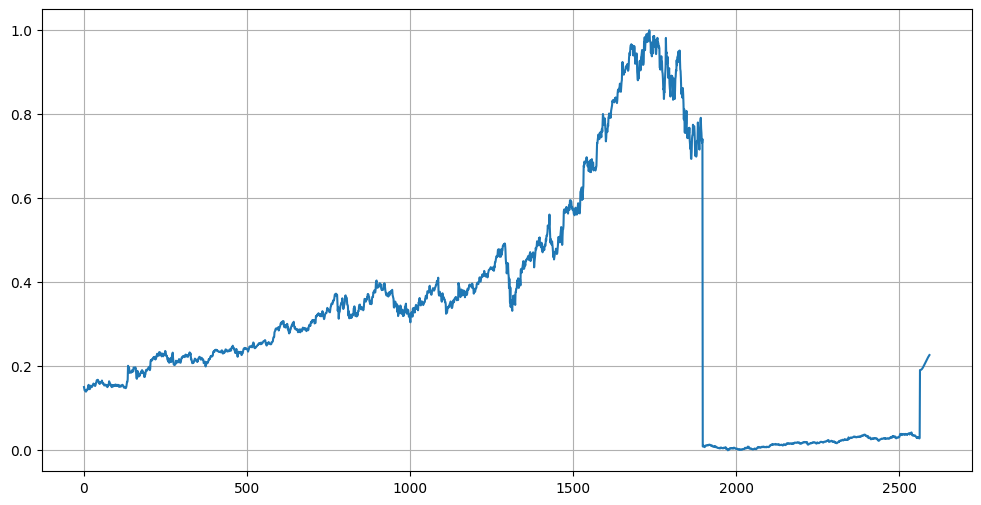

In [71]:
df3=df1.tolist()
df3.extend(lst_output)
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df3[:])

In [72]:
df3=scaler.inverse_transform(df3).tolist()

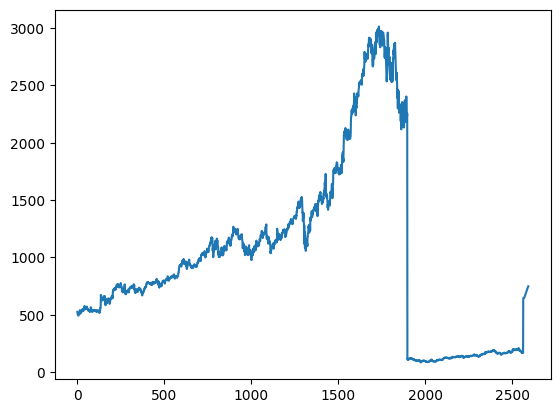

In [73]:
plt.plot(df3)

In [74]:
model.save('Stock Predictions Model.keras')